In [1]:
from pyrosm import get_data, OSM
import osmnx as ox
import os
import xarray
import math

/opt/anaconda3/envs/sentsegm/lib/python3.9/site-packages/pyrosm/utils/__init__.py:8: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
from typing import Optional, Iterable, Tuple
import requests
import pandas as pd
from pathlib import Path
from tqdm import tqdm

def download_tile_with_progress(tile_id: str, output_file: Path, access_token: str):
    url = f"https://catalogue.dataspace.copernicus.eu/odata/v1/Products({tile_id})/$value"
    
    s = requests.Session()
    s.headers.update({"Authorization": f"Bearer {access_token}"})
    
    response = s.head(url, allow_redirects=False)
    while response.status_code in (301, 302, 303, 307):
        url = response.headers['Location']
        response = s.head(url, allow_redirects=False)
    
    chunk_size = 2**20  # mb
    with s.get(url, stream=True) as resp:
        with open(output_file, "wb") as f:
            print(f"Saving to {output_file}")
            for data in tqdm(
                resp.iter_content(chunk_size=chunk_size), 
                total=int(resp.headers.get("content-length", 0)) // chunk_size, 
                unit="MB",
                unit_scale=True,
                desc="Downloading...",
            ):
                f.write(data)

# if not os.path.exists(tile_path_zip):
#     print(f"Downloading tile with ID {tile_id}")
#     download_tile_with_progress(tile_id, tile_path_zip, access_token)

In [26]:
cities = ["Berlin", "Milan", "sanktpetersburg", "Odessa", "New York", "London", "Krasnodar", "Paris", "Barcelona", "Amsterdam"]

data_dir = "./osm_data" 
os.makedirs(data_dir, exist_ok=True)
data = get_data(cities[2], update=False, directory=data_dir)

Downloaded Protobuf data 'SanktPetersburg.osm.pbf' (29.29 MB) to:
'/Users/arinash/Documents/uni/Sentinel-Segmentation/osm_data/SanktPetersburg.osm.pbf'


In [27]:
osm = OSM(data)
buildings = osm.get_buildings()

/opt/anaconda3/envs/sentsegm/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/anaconda3/envs/sentsegm/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/anaconda3/envs/sentsegm/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/anaconda3/envs/sentsegm/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/anaconda3/envs/sentsegm/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/anaconda3/envs/sentsegm/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/anaconda3/envs/sentsegm/lib/python3.9/sit

KeyboardInterrupt: 

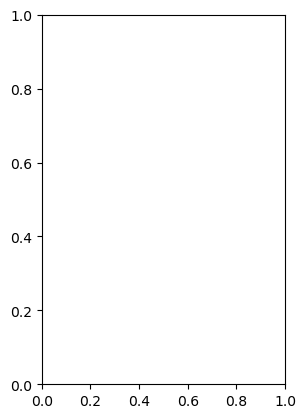

In [10]:
buildings.plot()

In [11]:
buildings = ox.features_from_place("Berlin", tags={'building':True})

/opt/anaconda3/envs/sentsegm/lib/python3.9/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/envs/sentsegm/lib/python3.9/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/opt/anaconda3/envs/sentsegm/lib/python3.9/site-packages/pygeos/predicates.py:764: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/envs/sentsegm/lib/python3.9/site-packages/pygeos/predicates.py:764: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/envs/sentsegm/lib/python3.9/site-packages/pygeos/predicates.py:764: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/envs/sentsegm/lib/python3.9/site-packages/pygeos/predicates.py:764: RuntimeWarning: invalid va

/Users/maxim/micromamba/envs/amls/lib/python3.10/site-packages/pandas/core/frame.py:706: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/Users/maxim/micromamba/envs/amls/lib/python3.10/site-packages/geopandas/geodataframe.py:1534: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/Users/maxim/micromamba/envs/amls/lib/python3.10/site-packages/geopandas/geodataframe.py:1534: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)
/Users/maxim/micromamba/envs/amls/lib/python3.10/site-packages/geopandas/geoseries.py:230: DeprecationWarning: Passing a SingleBlockManager to GeoSeries is deprecated and will raise in a future version. Use public APIs instead.
  su

<Axes: >

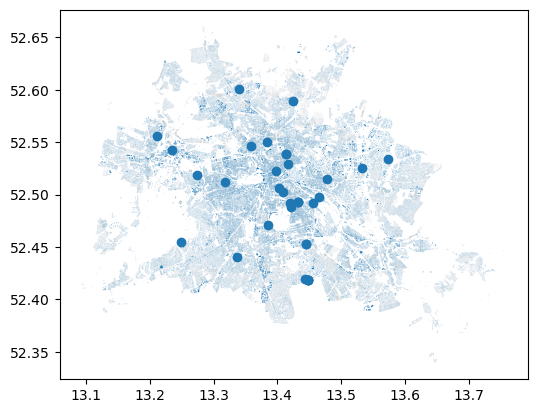

In [26]:
buildings.plot()

In [28]:
import openeo

connection = openeo.connect("openeo.dataspace.copernicus.eu")
connection.authenticate_oidc()


Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

In [36]:
G = ox.graph_from_place('bologna', network_type='drive')
node_id = list(G.nodes)[0]
G.nodes[node_id]['x'] #lon
G.nodes[node_id]['y']

/opt/anaconda3/envs/sentsegm/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/anaconda3/envs/sentsegm/lib/python3.9/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/envs/sentsegm/lib/python3.9/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/opt/anaconda3/envs/sentsegm/lib/python3.9/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/envs/sentsegm/lib/python3.9/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)


44.5241358

In [37]:
#from openeo.processes import collection, filter_bbox, filter_daterange, download

def download_sentinel_openeo(connection, latitude, longitude):
    offset = 1.0 / 1000.0;
    latNorth = latitude + 0.1
    latSouth = latitude - 0.1

    lngOffset = offset * math.cos(latitude * math.pi / 180.0)
    lngEast = longitude + 0.1
    lngWest = longitude - 0.1
    
    s2_cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=("2022-05-01", "2022-05-30"),
    spatial_extent={
        "west": lngWest,
        "south": latSouth,
        "east": lngEast,
        "north": latNorth,
        "crs": "EPSG:4326",
    },
    bands=["B04", "B03", "B02", "SCL"],
    max_cloud_cover=50,
    )
    
    s2_cube.download("load-raw.nc")

In [38]:
longitude = G.nodes[node_id]['x'] #lon
latitude = G.nodes[node_id]['y'] #lat

download_sentinel_openeo(connection, latitude, longitude)

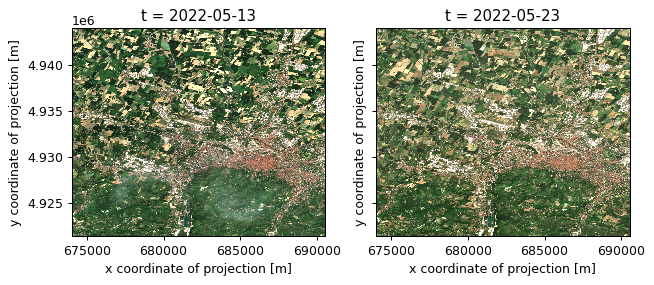

In [39]:
from matplotlib import pyplot as plt

ds = xarray.load_dataset("load-raw.nc")
# Convert xarray DataSet to a (bands, t, x, y) DataArray
data = ds[["B04", "B03", "B02"]].to_array(dim="bands")

fig, axes = plt.subplots(ncols=2, figsize=(8, 3), dpi=90, sharey=True)
data[{"t": 0}].plot.imshow(vmin=0, vmax=2000, ax=axes[0])
data[{"t": -1}].plot.imshow(vmin=0, vmax=2000, ax=axes[1]);